In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit

In [2]:
data_file = "adult_subsample.csv"
df = pd.read_csv(data_file)
df.head()

,workclass,education,marital-status,occupation,relationship,race,native-country,age,fnlwgt,education-nums,capital-gain,capital-loss,hours-per-week,sex,>50K
0,2,4,1,5,3,1,1,52,209642,9,0,0,45,0,1
1,1,11,3,6,4,1,1,31,45781,14,14084,0,50,1,1
2,1,1,1,5,3,1,1,42,159449,13,5178,0,40,0,1
3,1,2,1,5,3,5,1,37,280464,10,0,0,80,0,1
4,6,1,1,6,3,2,8,30,141297,13,0,0,40,0,1


In [3]:
# Partition into predictor and response variables
X = df.iloc[:,:-1].values
y = df.iloc[:, -1].values

# Normalize X
scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)
print(X.shape)

(1000, 14)


In [4]:
# Evaluate training error of Decision Tree classifier
print('Classifying using Decision Tree...')
clf = DecisionTreeClassifier(criterion='entropy')
clf.fit(X,y)
y_pred = clf.predict(X)
train_error = 1 - metrics.accuracy_score(y, y_pred, normalize=True)
print('\t-- training error: %.3f' % train_error)

Classifying using Decision Tree...
	-- training error: 0.000


In [5]:
# Evaluate training error of k-Nearest Neighbors classifier
# use k = 3, 5, 7 for n_neighbors
print('Classifying using k-Nearest Neighbors...')
for k in [3,5,7]:
  clf = KNeighborsClassifier(n_neighbors=k)
  clf.fit(X,y)
  y_pred = clf.predict(X)
  train_error = 1 - metrics.accuracy_score(y, y_pred, normalize=True)
  print('\t-- training error for k=%d: %.3f' % (k, train_error))

Classifying using k-Nearest Neighbors...
	-- training error for k=3: 0.114
	-- training error for k=5: 0.129
	-- training error for k=7: 0.152


In [6]:
def error(clf, X, y, ntrials=100, test_size=0.2) :
    """
    Computes the classifier error over a random split of the data,
    averaged over ntrials runs.
    """

    sss = StratifiedShuffleSplit(ntrials, test_size=test_size, random_state=0)
    train_error, test_error, f1_score = 0, 0, 0

    for train_index, test_index in sss.split(X, y):
      X_train, X_test = X[train_index], X[test_index]
      y_train, y_test = y[train_index], y[test_index]
      
      # Training error
      clf.fit(X_train, y_train)
      y_pred = clf.predict(X_train)
      train_error += 1 - metrics.accuracy_score(y_train, y_pred, normalize=True)
      
      # Validation error
      y_pred = clf.predict(X_test)
      test_error += 1 - metrics.accuracy_score(y_test, y_pred, normalize=True)
      f1_score += metrics.f1_score(y_test, y_pred, average='micro')

    # Average returns
    train_error, test_error, f1_score = [x/ntrials for x in [train_error, test_error, f1_score]]

    return train_error, test_error, f1_score

In [7]:
# Use cross-validation to compute average training and test error of classifiers
print('Investigating various classifiers...')

print('Cross-validation using Decision Tree...')
clf = DecisionTreeClassifier(criterion='entropy')
train_error, test_error, f1_score = error(clf, X, y)
print('\t-- training error: %.3f' % train_error)
print('\t-- testing error: %.3f' % test_error)
print('\t-- f1 score: %.3f' % f1_score)

k = 5
print('Cross-validation using %d-Nearest Neighbors' % k)
clf = KNeighborsClassifier(n_neighbors=k)
train_error, test_error, f1_score = error(clf, X, y)
print('\t-- average training error: %.3f' % train_error)
print('\t-- average testing error: %.3f' % test_error)
print('\t-- f1 score: %.3f' % f1_score)

Investigating various classifiers...
Cross-validation using Decision Tree...
	-- training error: 0.000
	-- testing error: 0.205
	-- f1 score: 0.795
Cross-validation using 5-Nearest Neighbors
	-- average training error: 0.133
	-- average testing error: 0.209
	-- f1 score: 0.791


Finding the best k...


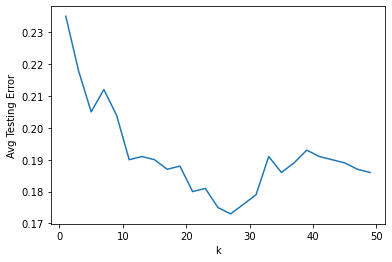

Best k:  27


In [8]:
# Use 10-fold cross-validation to find the best value of k for k-Nearest Neighbors classifier
print('Finding the best k...')
k_vals, err = [], []
for k in range(50):
  if k % 2 != 0:
    clf = KNeighborsClassifier(n_neighbors=k)
    accuracy_scorer = metrics.make_scorer(metrics.accuracy_score)
    k_vals.append(k)
    err.append(1 - np.average(cross_val_score(clf, X, y, cv=10, scoring=accuracy_scorer)))

plt.plot(k_vals, err)
plt.xlabel('k')
plt.ylabel('Avg Testing Error')
plt.show()

best_k = k_vals[np.argmin(err)]
print('Best k: ', best_k)

Investigating depths...


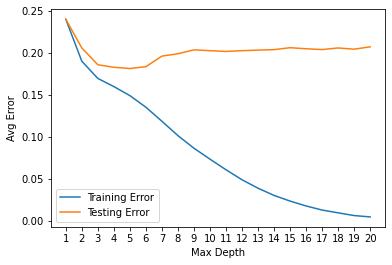

Best Max Depth:  5


In [9]:
# Investigate various maximum depths for Decision Tree classifier
print('Investigating depths...')
d_vals, train_err, test_err = [], [], []
for d in range(1, 21):
  clf = DecisionTreeClassifier(criterion='entropy', max_depth=d)
  train_error, test_error, _ = error(clf, X, y)
  d_vals.append(d)
  train_err.append(train_error)
  test_err.append(test_error)

plt.plot(d_vals, train_err, label='Training Error')
plt.plot(d_vals, test_err, label='Testing Error')
plt.xticks(range(1,21))
plt.xlabel('Max Depth')
plt.ylabel('Avg Error')
plt.legend(loc='lower left')
plt.show()

best_d = d_vals[np.argmin(test_err)]
print('Best Max Depth: ', best_d)